# Case study: CPA-catalyzed nucleophilic addition to imines (*Nature* **2019**)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import warnings

import sys
sys.path.append('../src/')
import RaRFRegressor
import utils

plt.rcParams['font.size'] = 14
COLORA = '#027F80'
COLORB = '#B2E5FC'


In [2]:
def prepare_dataset(path):

    original_df = pd.read_excel(path, sheet_name='df')
    imines = pd.read_excel(path, sheet_name='imine').set_index('Imine').to_dict(orient='index')
    ligands = pd.read_excel(path, sheet_name='ligand').set_index('ligand').to_dict(orient='index')
    solvents = pd.read_excel(path, sheet_name='solvent').set_index('solvent').to_dict(orient='index')
    nucs = pd.read_excel(path, sheet_name='nuc').set_index('Nucleophile').to_dict(orient='index')

    nuc_descriptors = []
    ligand_descriptors = []
    solvent_descriptors = []
    imine_descriptors = []

    for nuc in original_df['Nucleophile']:
        nuc_descriptors.append(nucs[nuc])

    for ligand in original_df['Ligand']:
        ligand_descriptors.append(ligands[ligand])

    for solvent in original_df['Solvent']:
        solvent_descriptors.append(solvents[solvent])

    for imine in original_df['Imine']:
        imine_descriptors.append(imines[imine])

    descriptors = pd.DataFrame.from_dict(nuc_descriptors).join(pd.DataFrame.from_dict(ligand_descriptors)).join(pd.DataFrame.from_dict(imine_descriptors)).join(pd.DataFrame.from_dict(solvent_descriptors))
    new_df = original_df.join(descriptors)

    return(new_df)

df = prepare_dataset('../data/Nature_2019.xlsx')
reduced_df = VarianceThreshold().fit_transform(df.iloc[:,6:])
df_train, df_test = train_test_split(reduced_df,train_size=0.8, random_state=25)

X_train = df_train[:,1:]
X_test = df_test[:,1:]
y_train = df_train[:,0]
y_test = df_test[:,0]

## RaRF Regression

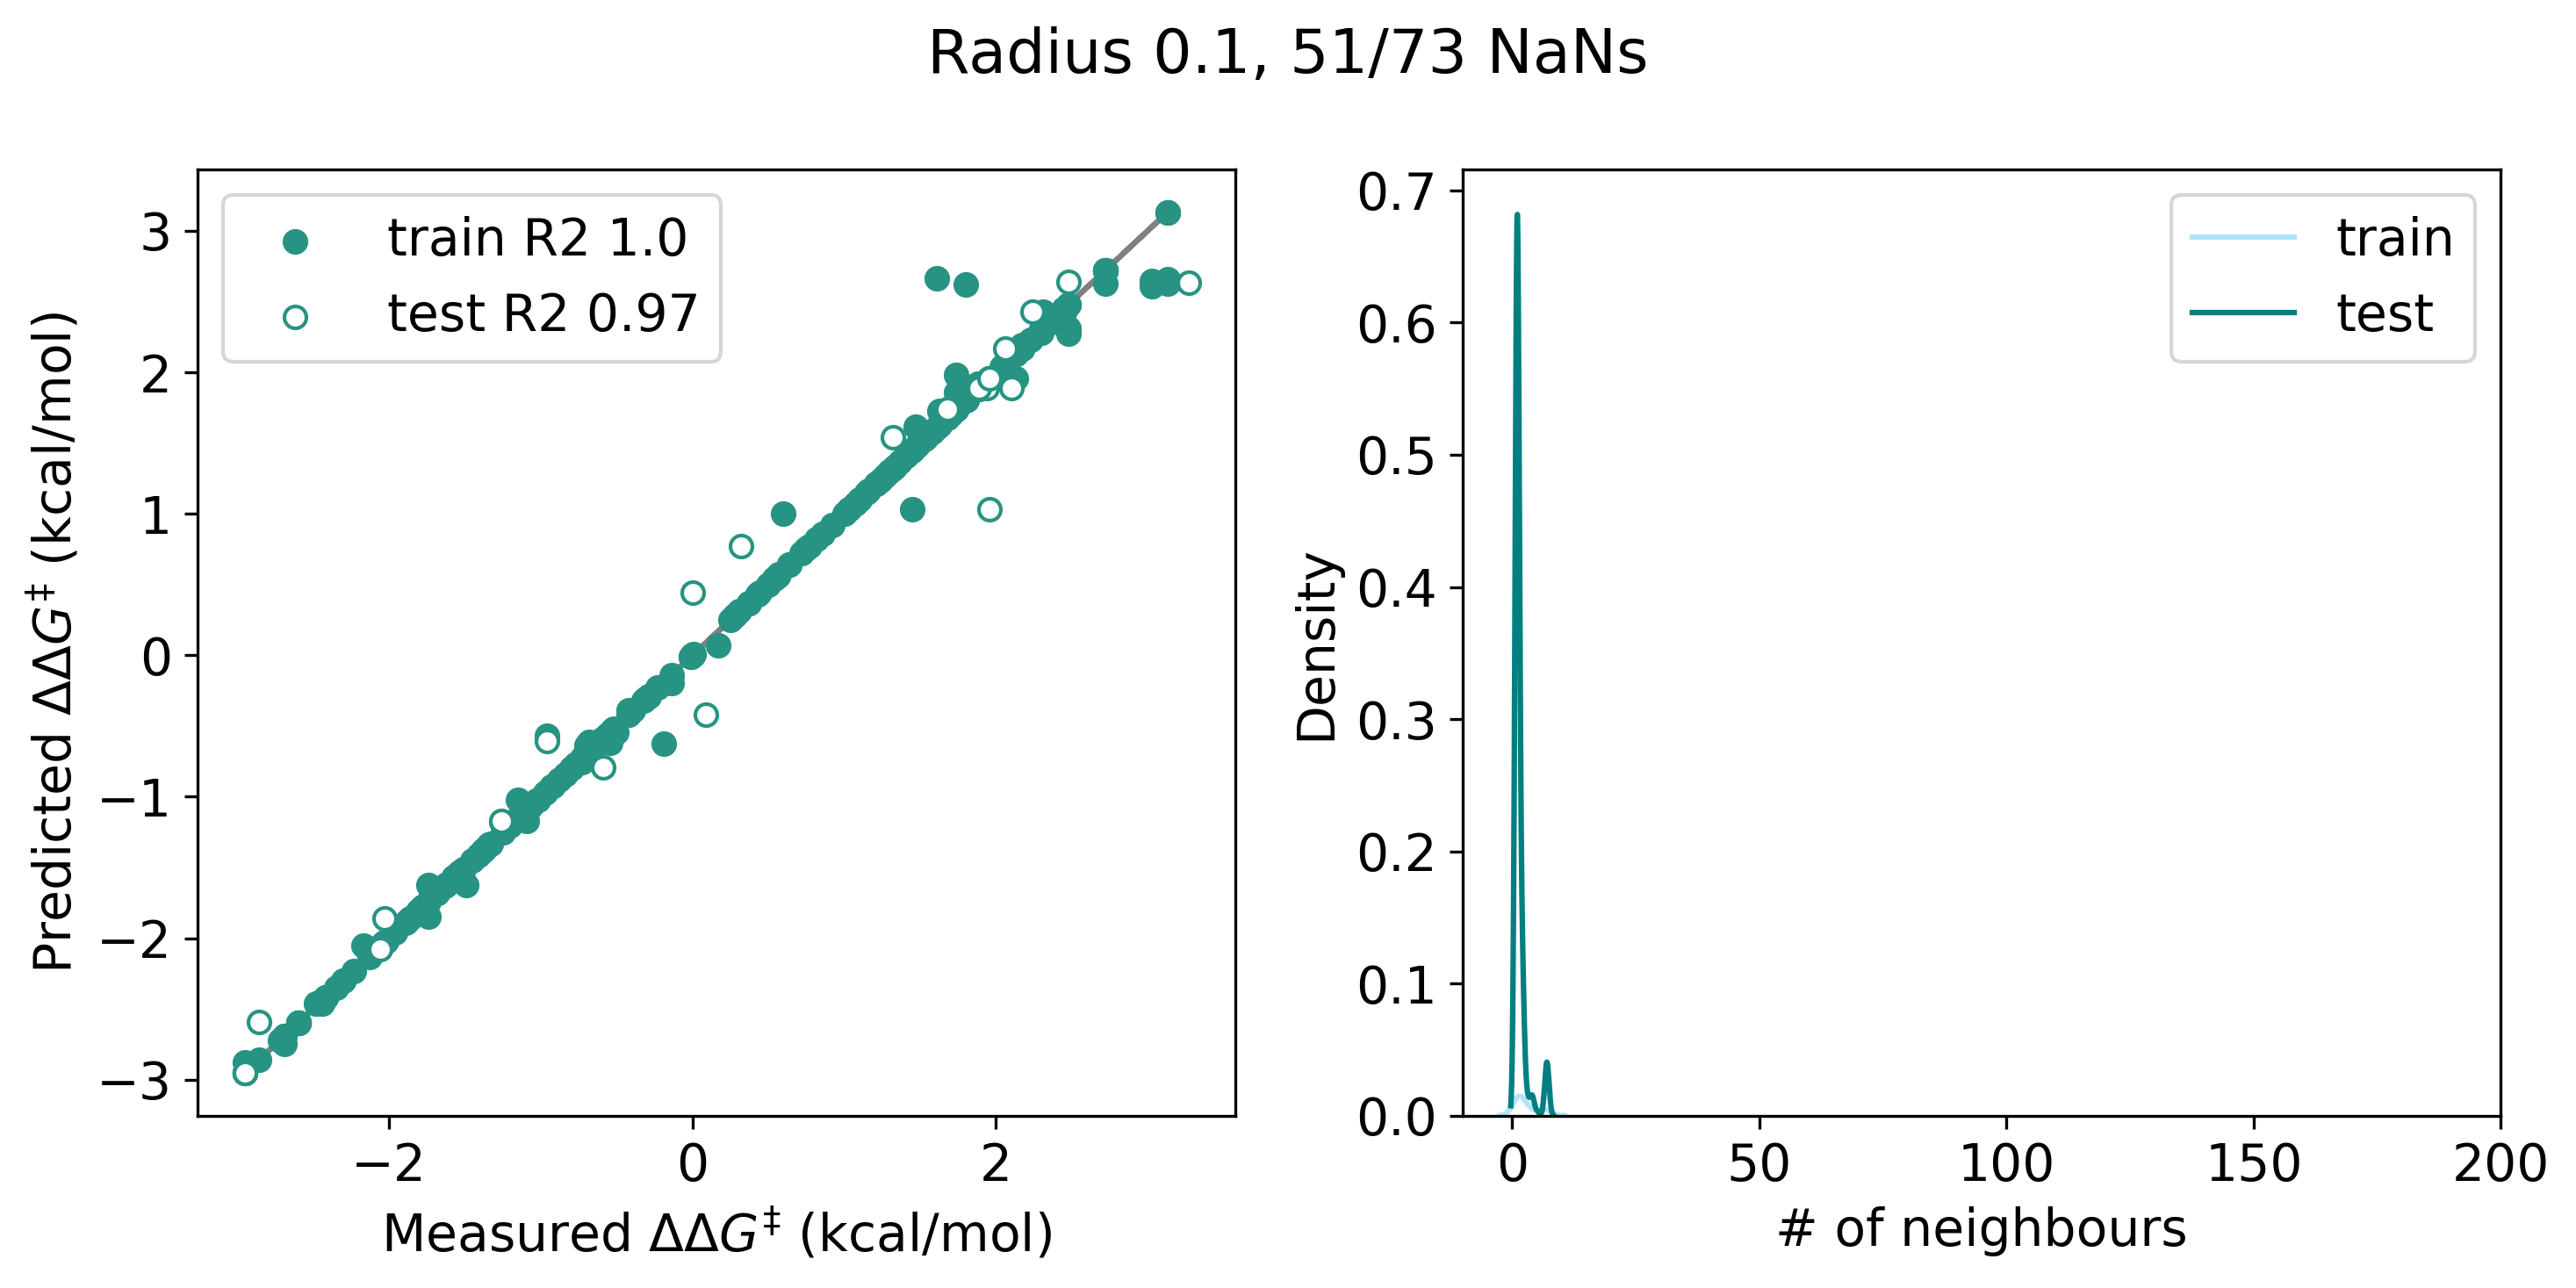

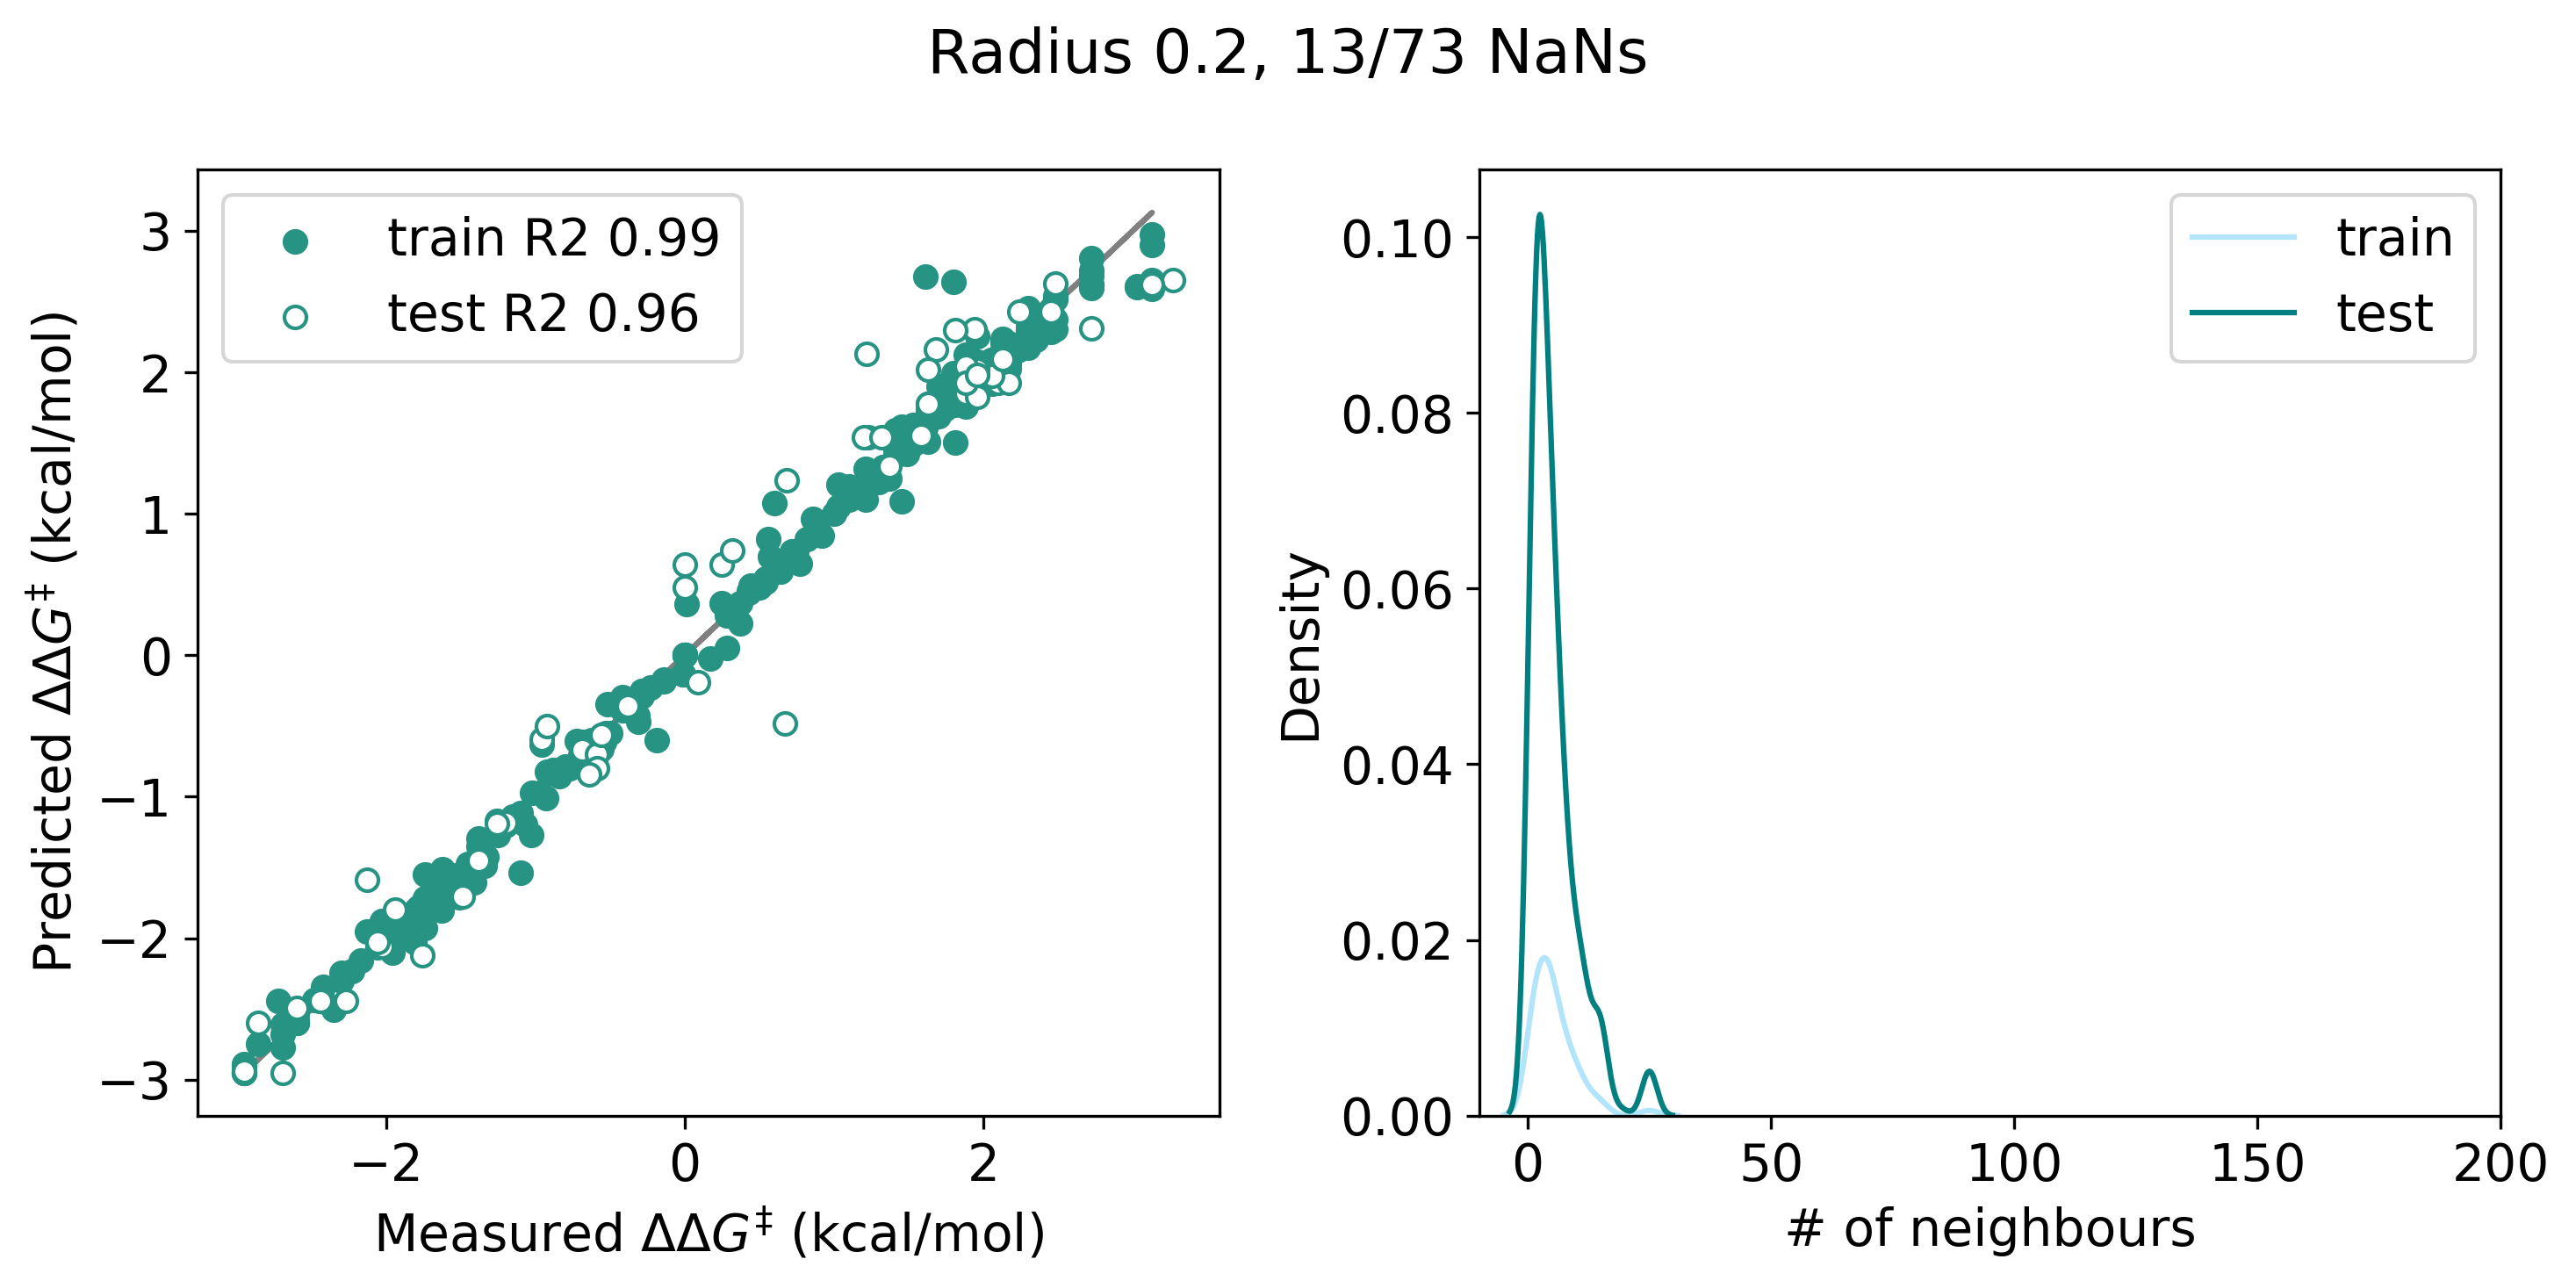

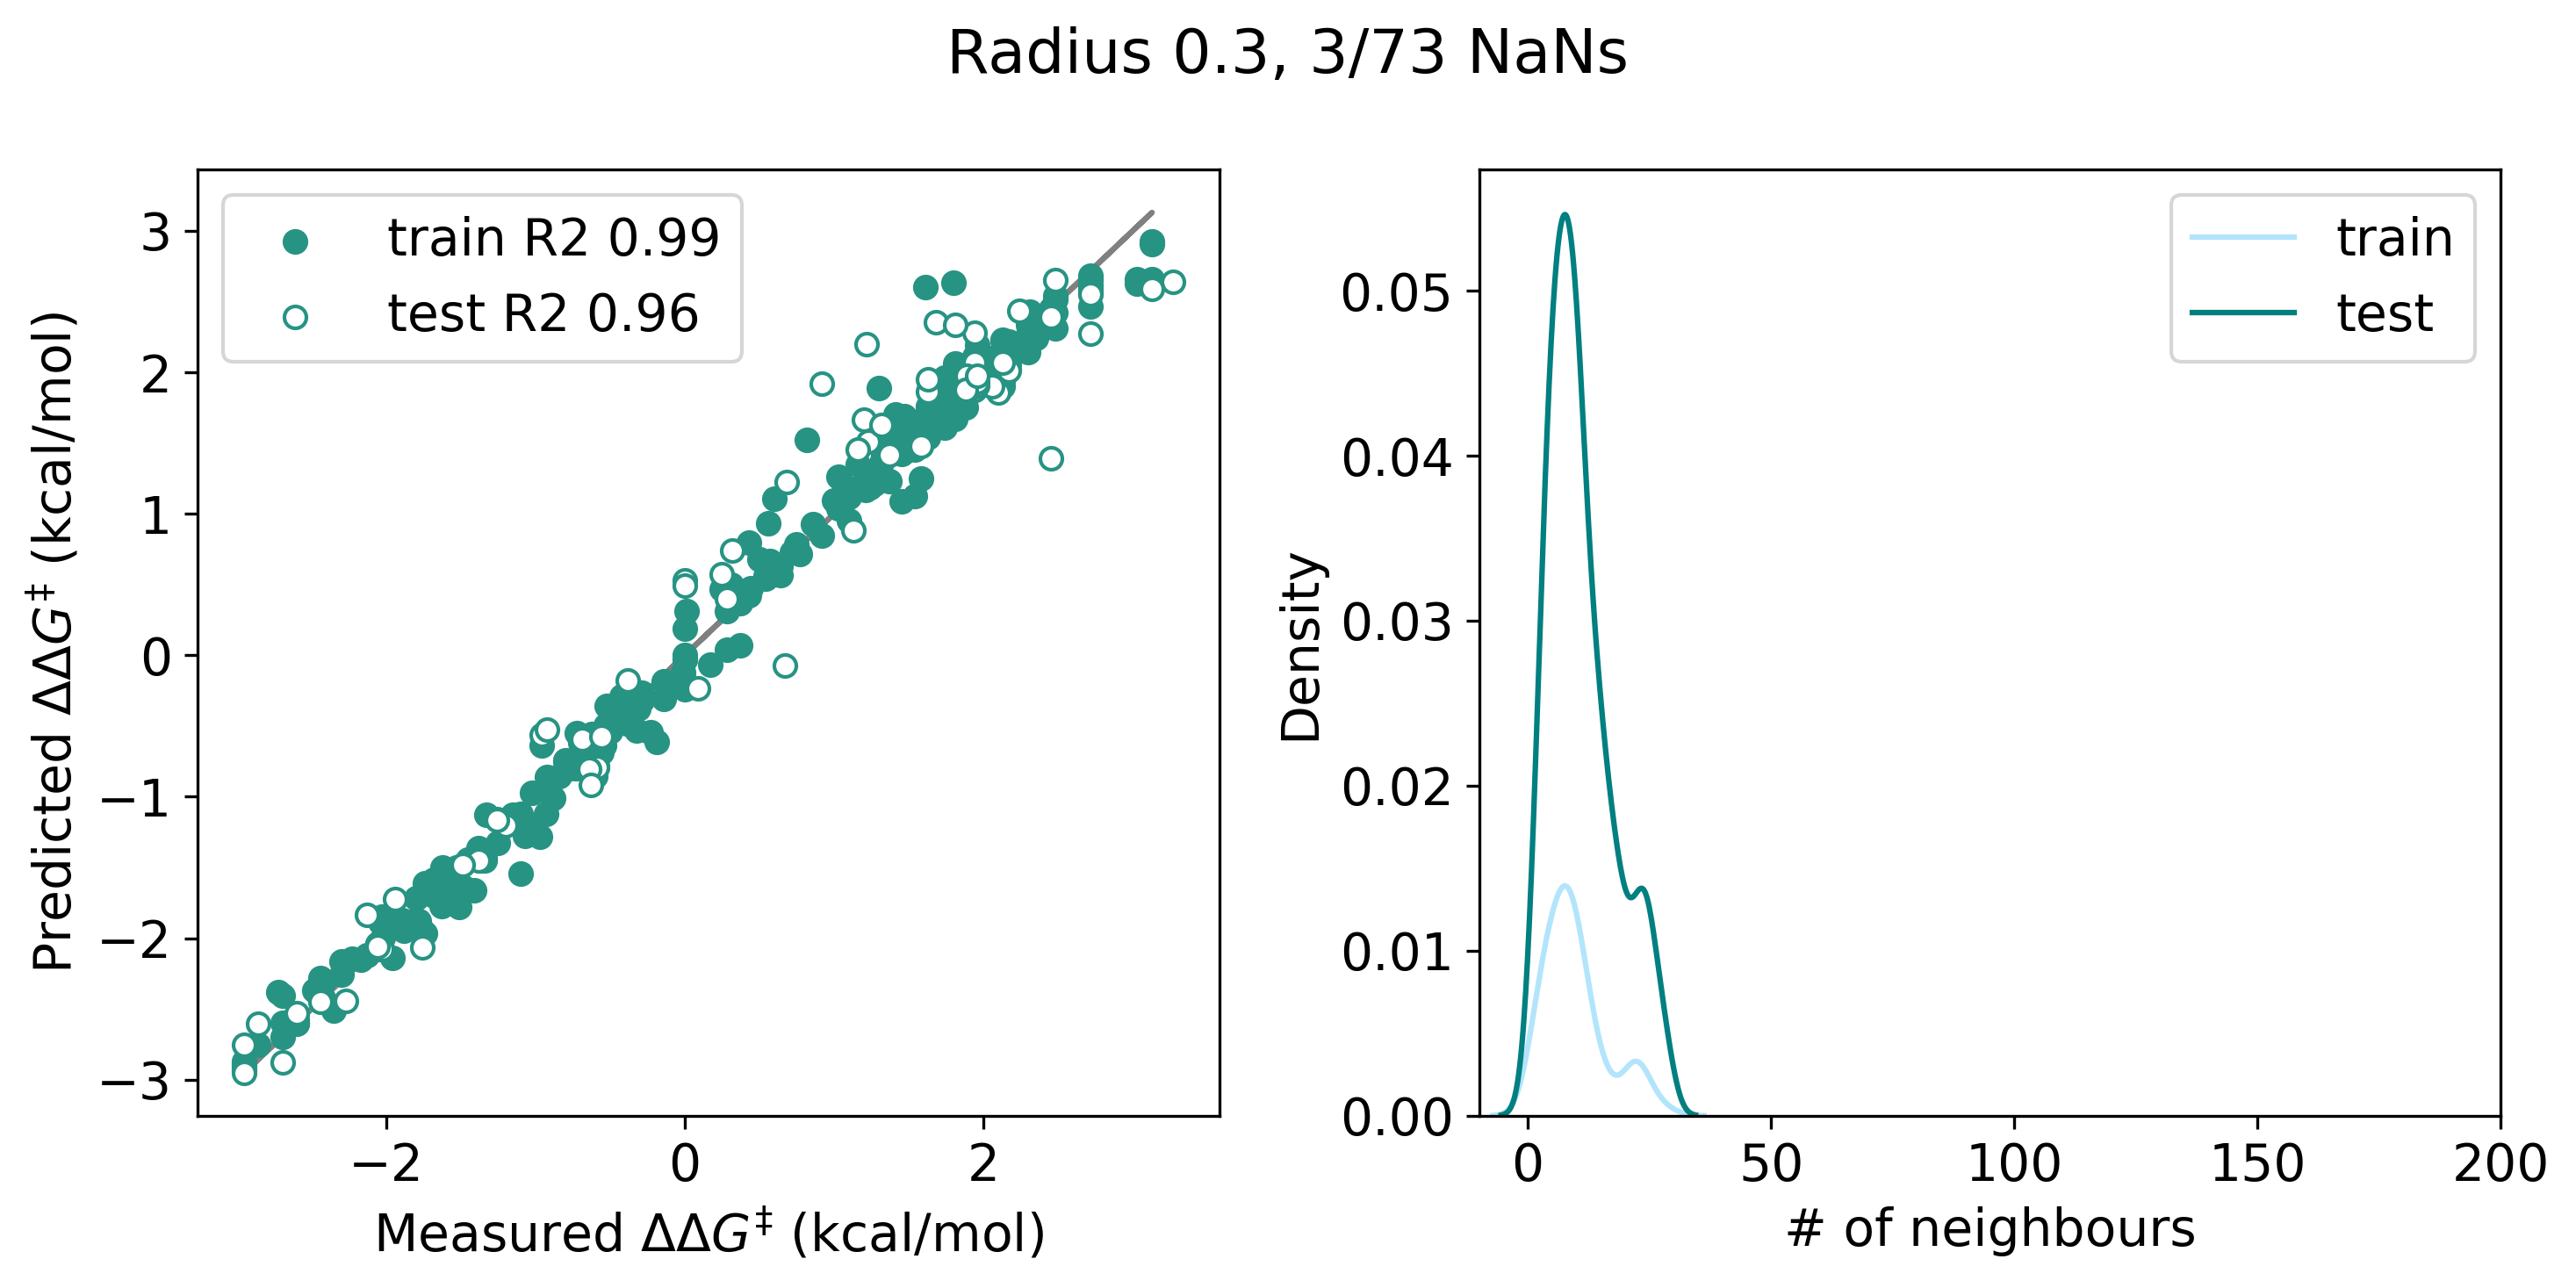

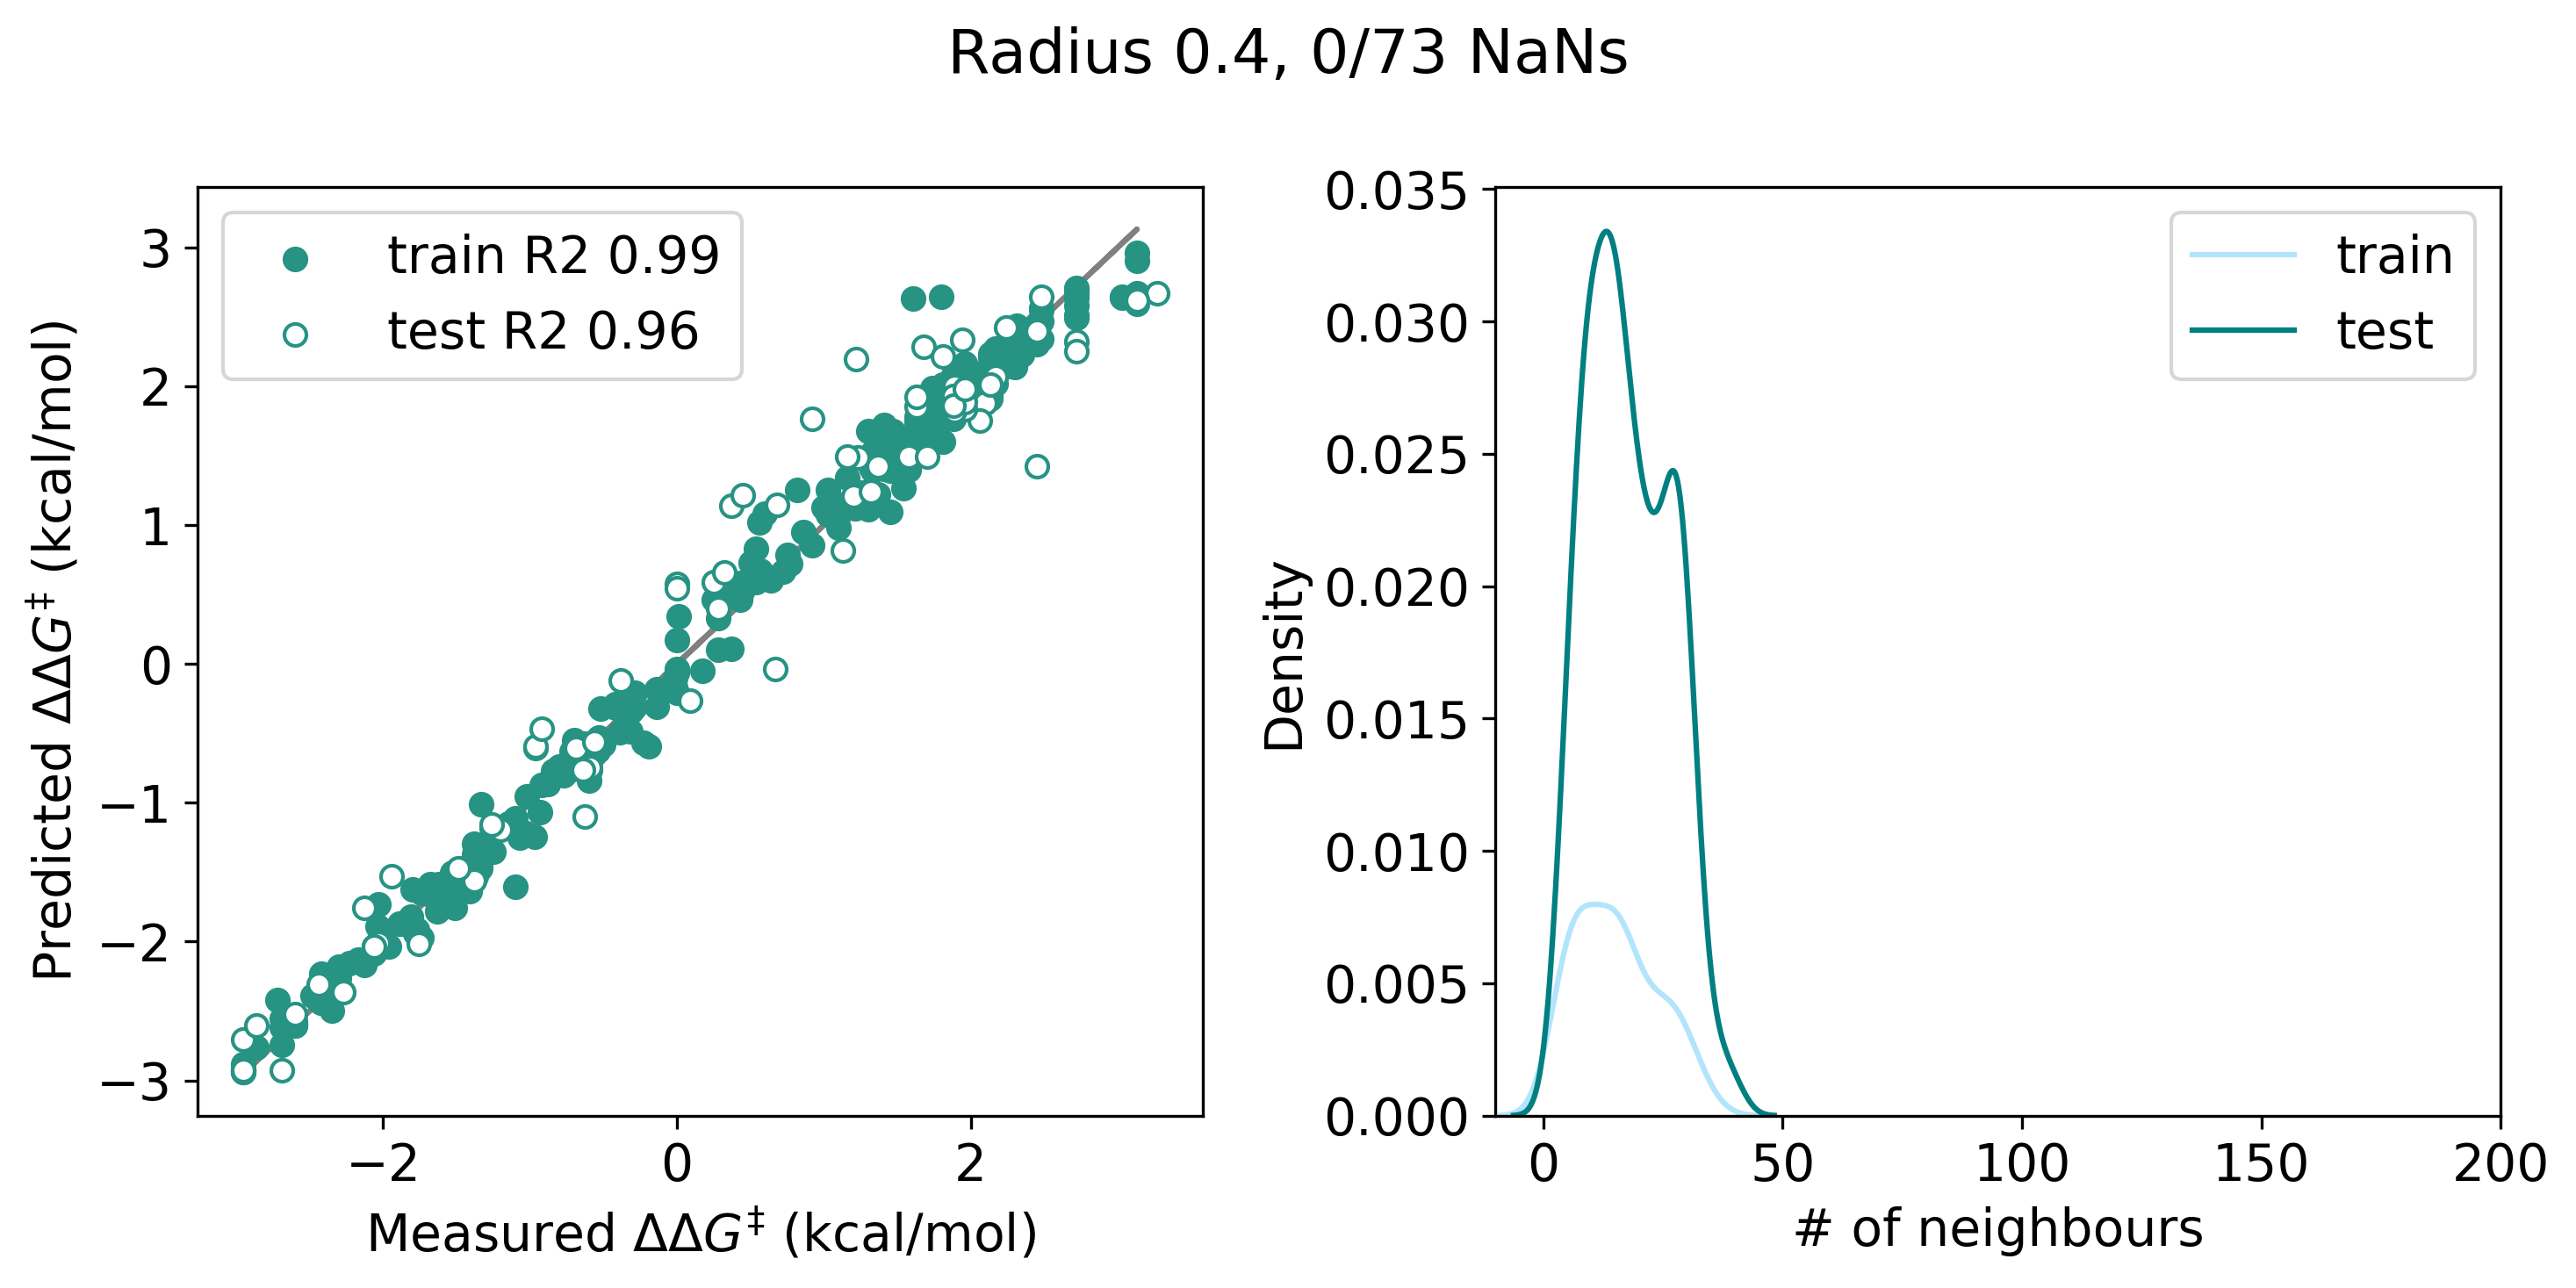

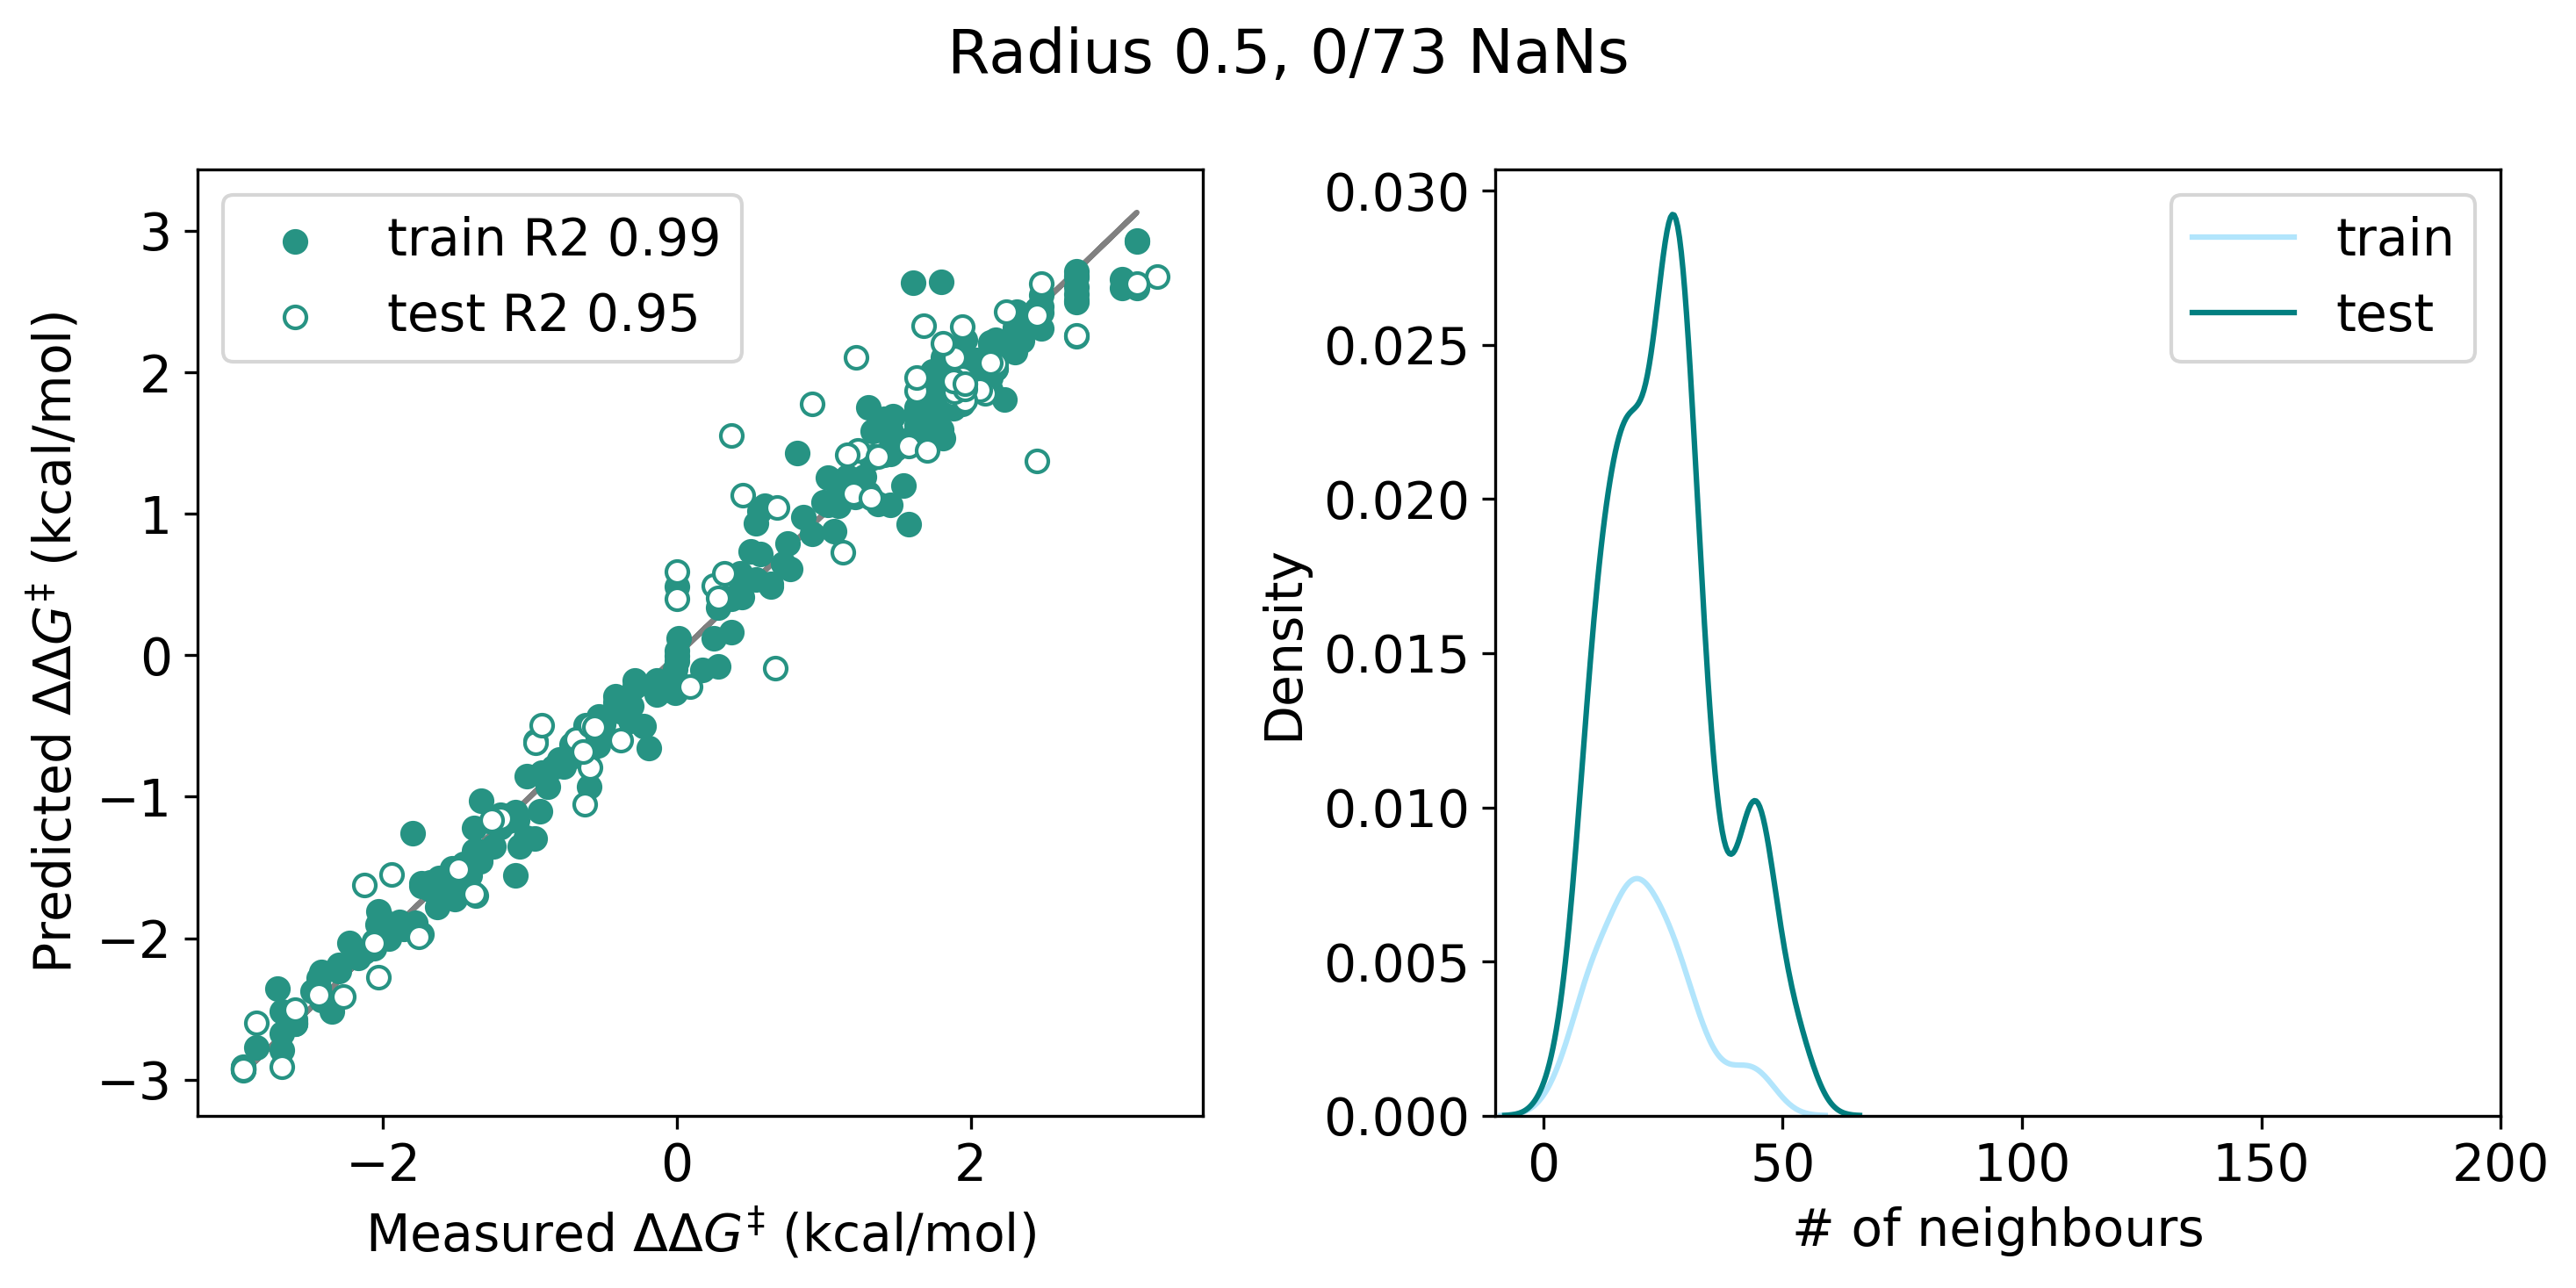

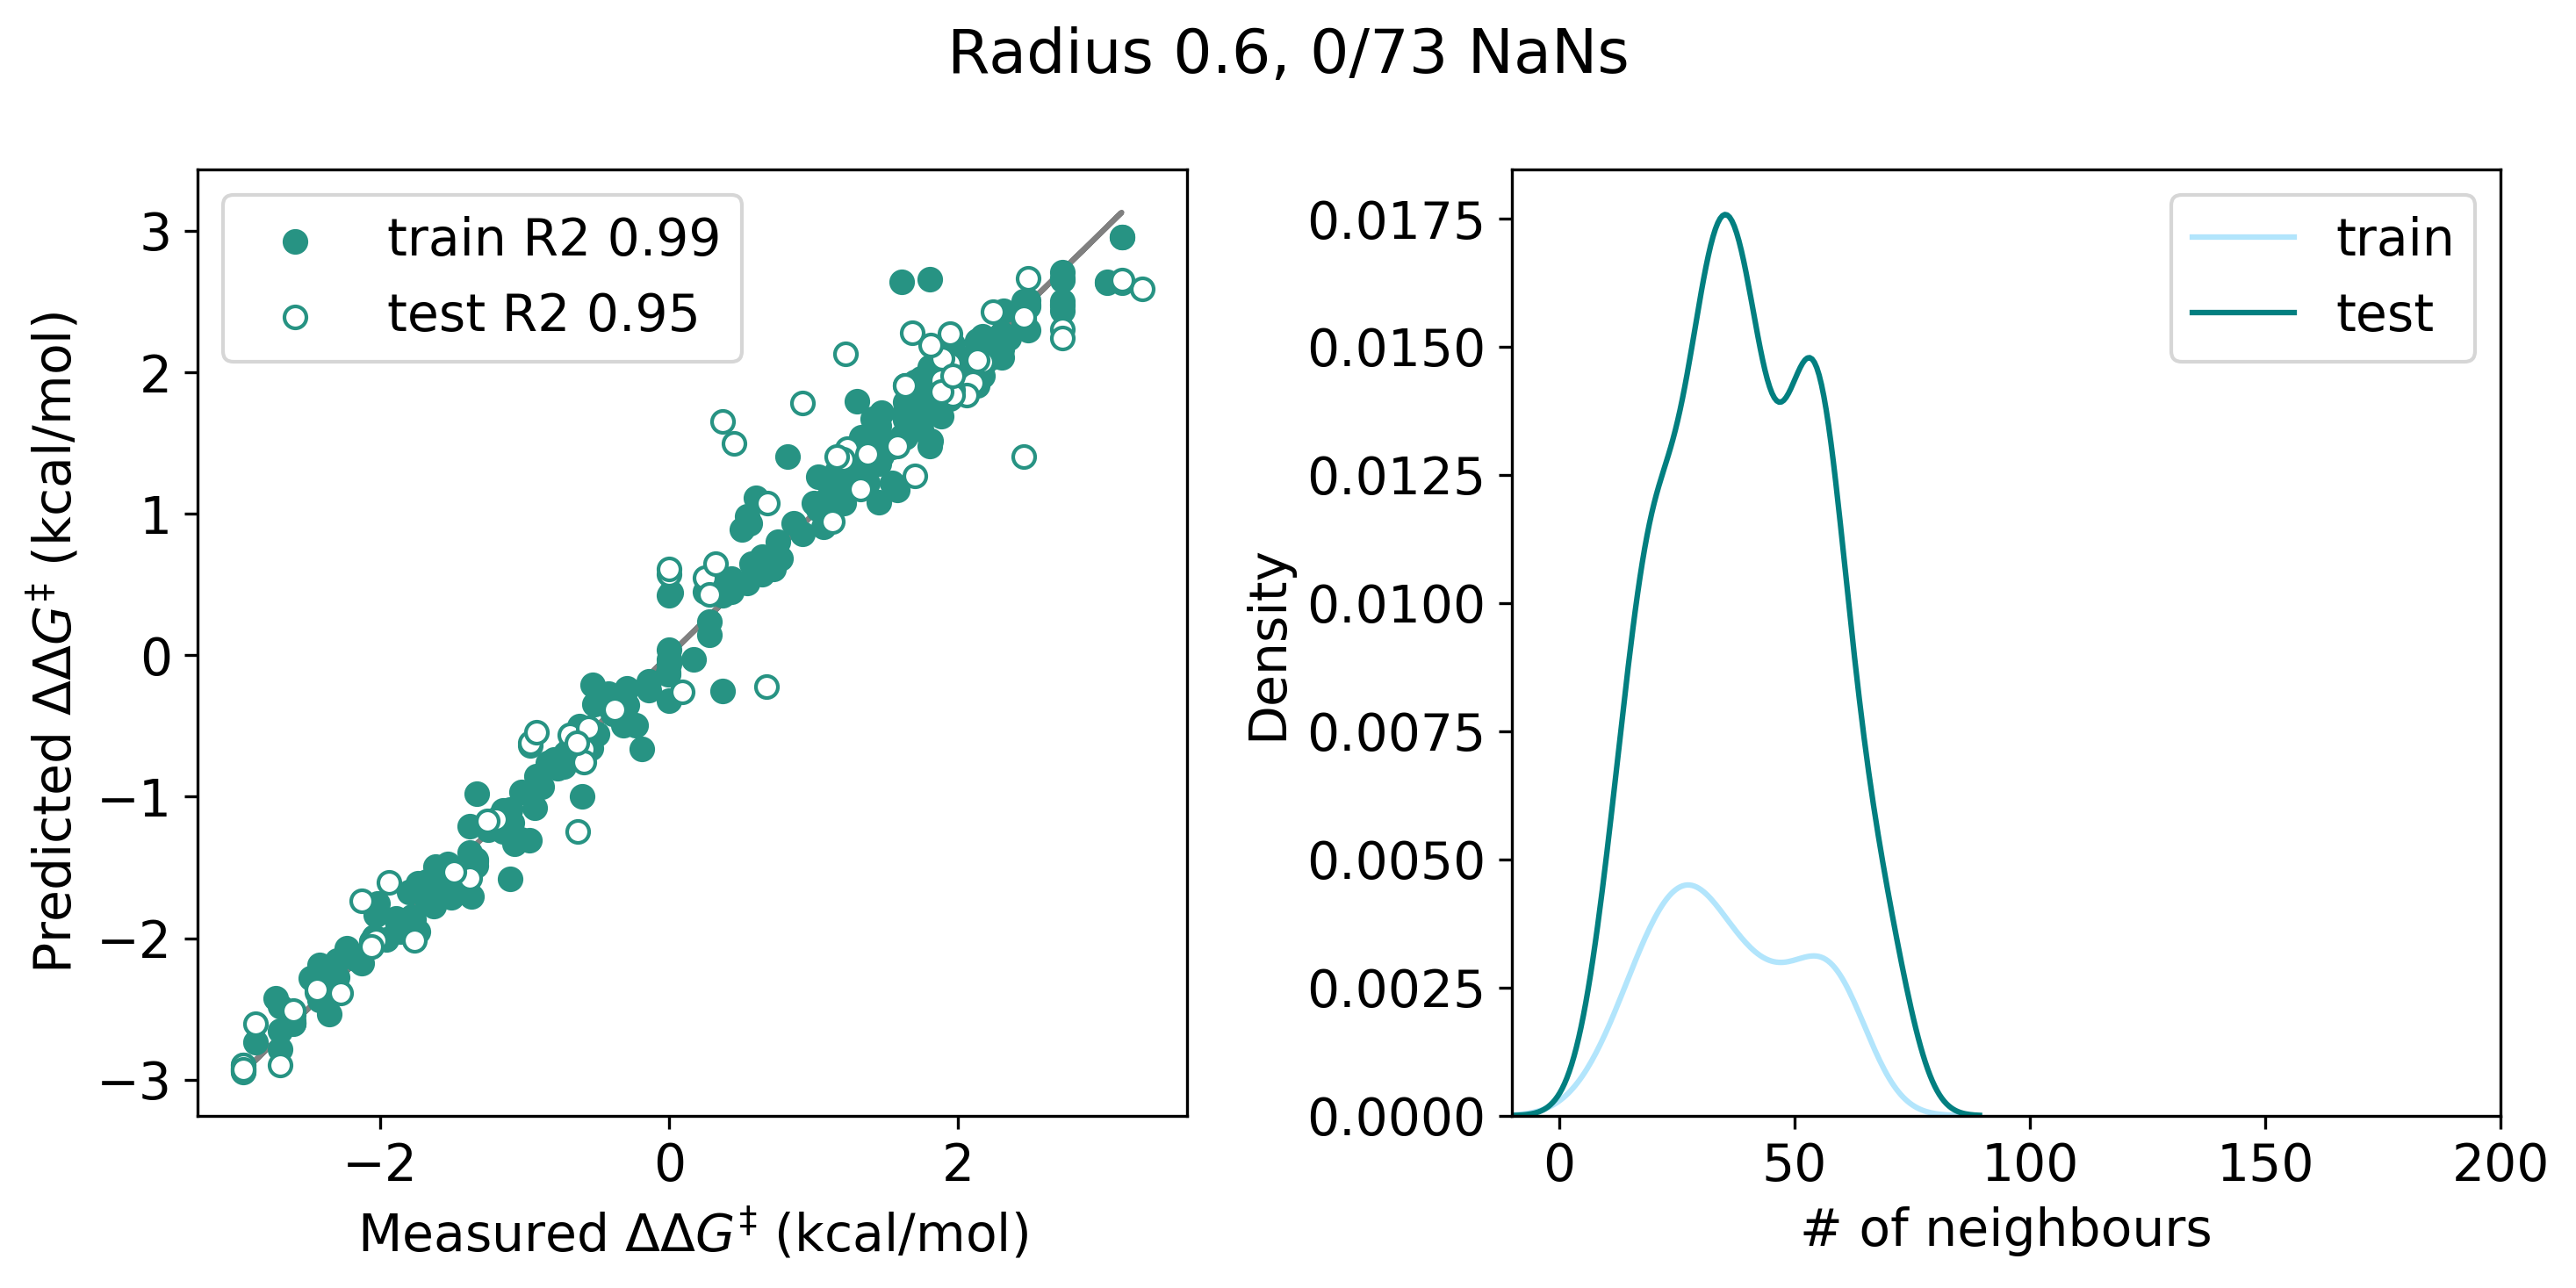

In [ ]:
RaRF_mae = []
nans = []
avg_neighbours = []

distances = utils.get_distances(X_train,X_test)

for i in np.divide(range(1,10),10):


    radius_pred, train_neighbours = RaRFRegressor.RaRFRegressor(radius=i, metric='jaccard').train_parallel(X_train,y_train, include_self='True')
    radius_testpred, test_neighbours, test_neighbours_list = RaRFRegressor.RaRFRegressor(radius=i,metric='jaccard').predict_parallel(X_train, y_train, X_test, distances)    

    test_neighbours = np.array(test_neighbours)
    nan_indexes = []
    index = -1
    for prediction in radius_testpred:
        index +=1
        if np.isnan(prediction) == True:
            nan_indexes.append(index)
        
    radius_testpred_temp = np.delete(radius_testpred,nan_indexes)
    y_test_temp = np.delete(y_test,nan_indexes)


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=300)


    ax1.plot(y_train,y_train, color='grey', zorder=0)
    ax1.scatter(y_train,radius_pred, label='train R2 ' + str(round(r2_score(y_train,radius_pred),2)), color='#279383')
    ax1.scatter(y_test_temp,radius_testpred_temp, label='test R2 ' + str(round(r2_score(y_test_temp,radius_testpred_temp,),2)), color='white', edgecolor='#279383')

    ax1.set_xlabel('Measured $\Delta\Delta G^‡$ (kcal/mol)')
    ax1.set_ylabel('Predicted $\Delta\Delta G^‡$ (kcal/mol)')
    ax1.legend()


    ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])
    ax2.legend(['train', 'test'])
    ax2.set_xlim(-10,200)
    ax2.set_xlabel('# of neighbours')

    fig.suptitle(f'Radius {i}, {len(nan_indexes)}/{len(radius_testpred)} NaNs')
    plt.tight_layout()
    plt.show()

    RaRF_mae.append(mean_absolute_error(y_test_temp,radius_testpred_temp))
    
    nans.append(len(nan_indexes))

    avg_neighbours.append(np.average([test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]))

